# DTSA 5509 - Intro to Machine Learning: Supervised | Final Project

# Project topic
This project seeks to compare how well different supervised learning techniques perform in determining whether a given image should be classified as a left turn or a right turn. The images to be used are from the first-person perspective of a vehicle driver. The classification techniques used in this notebook include:
- Logistic Regression
- kNN (with various k)
- Decision Tree (with various max_depth and various max_leaf_nodes)

While more advanced machine learning techniques are used these days for image recognition (such as convolutional neural networks for self-driving car applications in particular), this project serves to assess these more fundamental techniques. They're less complex in nature, require less computing power to train and test, and could prove useful as a pre-processing layer(s) in a larger implementation.

The initial dataset is fairly straightforward, containing 63,825 rows of data (images and corresponding steering angles):
- Images ([256 px H x 455 px W x 3 color channels (BGR)], .jpg format, 3.25 GB)
- Steering angle ([-388.82, 252.61], .csv format, 1.1 MB)

Positive Steering angle values indicate a clockwise turn (right) while negative values indicate a counterclockwise turn (left). Part of the preprocessing of the Images will be to flatten their 3D structure into a 1D structure, where ultimately each pixel's brightness will correspond to a feature $X_{i, n}$. The steering angle will then correspond to the associated steering direction (-1 for left turns, +1 for right turns) $y_i$. 

The data was provided by Sully Chen via his driving-datasets repository on GitHub: https://github.com/SullyChen/driving-datasets. It is offered via the MIT license.

In [1]:
import time
import cv2
import warnings
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree

# Angles

Import, sample, and EDA the angles dataset:

In [2]:
angles = pd.read_csv('angles.csv')

In [3]:
np.random.seed(0)
angles = angles.sample(len(angles))

print(angles.info())
print(angles.describe())
angles.head()

<class 'pandas.core.frame.DataFrame'>
Index: 63825 entries, 60407 to 2732
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Image   63825 non-null  object 
 1   Angle   63825 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB
None
              Angle
count  63825.000000
mean       1.256541
std       26.605094
min     -338.820007
25%       -4.340000
50%        1.510000
75%        7.060000
max      252.610001


,Image,Angle
60407,60407.jpg,19.059999
2737,2737.jpg,0.910000
57396,57396.jpg,-2.220000
12709,12709.jpg,3.430000
53192,53192.jpg,5.450000


Since these images and steering angles were obtained from many continuous trips on public roads (relatively straight roads, continued to record while stopped at intersections, etc.), there are likely many images corresponding to relatively insignificant steering angles. Let's see how many samples have steering angles below a certain threshold:

In [4]:
min_angle_magnitude = 5

insig_left = angles['Angle'] <= min_angle_magnitude
insig_right = angles['Angle'] >= -min_angle_magnitude
insig_angle = angles[insig_left & insig_right]

print(f'Percent < |min steering angle|: {np.round(insig_angle.shape[0]/angles.shape[0], 3)*100}%')

Percent < |min steering angle|: 48.9%


Based on the amount of insignificant steering data found above, we will end up using a much smaller subset of data from the initial dataset provided.
## Images
Sample image:

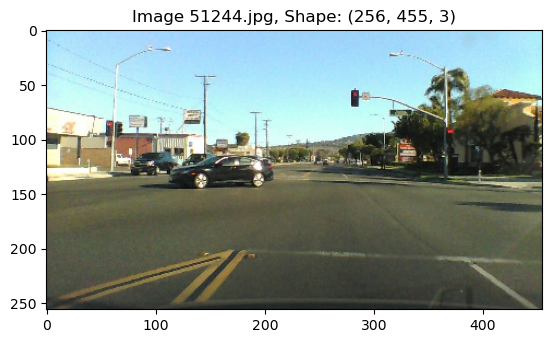

In [5]:
sample_img = angles['Image'].iloc[np.random.randint(0, len(angles))]
img = cv2.imread(f'images/{sample_img}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'Image {sample_img}, Shape: {img.shape}')
plt.show()

## Vectorizing the images

In order to work with the images, we will need to vectorize them. Using the OpenCV library, each pixel of each image will have its BGR color composition identified.

`cv2.imread(image)` produces a 3D vector from `image` with the following characteristics:
- Dimension 1: Row
- Dimension 2: Column
- Dimension 3: BGR values

`cv2.cvtColor(image, cv2.COLOR_BGR2RGB)` switches the sorting of the values in dimension 3 such that the values of `image[row][col][x]` correspond to red, green, and blue rather than blue, green, and red. `cv2.imread()`'s default output is BGR but matplotlib uses RGB.

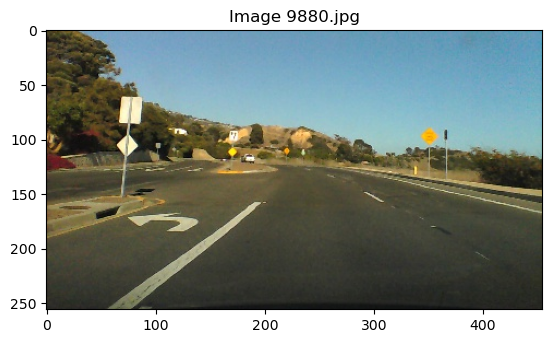

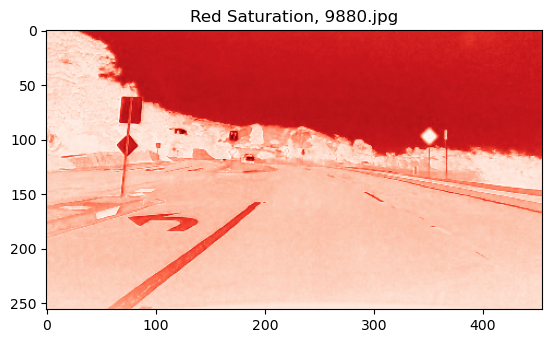

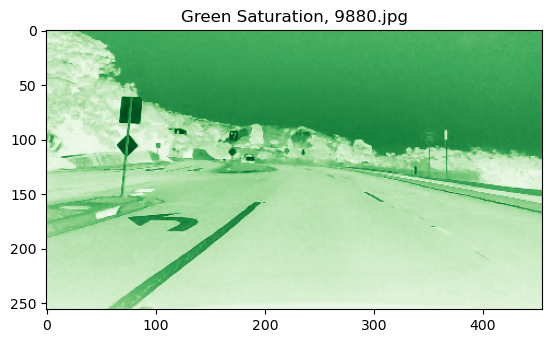

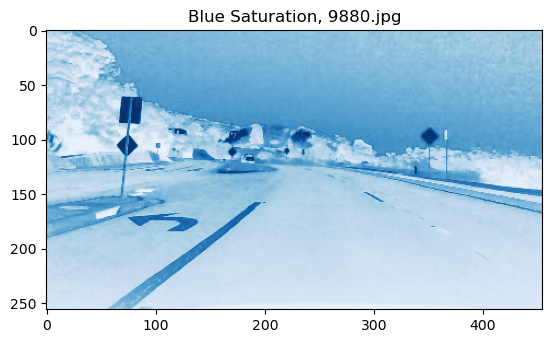

In [6]:
# Interesting samples to try for RGB differences:
#    500: saturation of sky; red vs blue
#    3700: gradient across sky in red & green but not blue
#    5560: tail lights of cars, red vs blue & green
#    9880: contrast of median, trees, and obstacles- especially the "yellow" sign on the right
sample_img_idx = 9880

sample_rgb_img = cv2.imread(f'images/{sample_img_idx}.jpg')
sample_rgb_img = cv2.cvtColor(sample_rgb_img, cv2.COLOR_BGR2RGB)

h, w, n_channels = sample_rgb_img.shape
r_values = np.zeros((h, w), dtype=np.float32)
g_values = np.zeros((h, w), dtype=np.float32)
b_values = np.zeros((h, w), dtype=np.float32)
brightness = np.zeros((h, w), dtype=np.float32)

for y in range(h):
    for x in range(w):
        b, g, r = sample_rgb_img[y, x]
        r = np.float32(r)
        g = np.float32(g)
        b = np.float32(b)
        r_values[y, x] = r
        g_values[y, x] = g
        b_values[y, x] = b
        brightness[y, x] = (r + g + b)/3

plt.imshow(sample_rgb_img)
plt.title(f'Image {sample_img_idx}.jpg')
plt.show()

plt.imshow(r_values, cmap='Reds')
plt.title(f'Red Saturation, {sample_img_idx}.jpg')
plt.show()

plt.imshow(g_values, cmap='Greens')
plt.title(f'Green Saturation, {sample_img_idx}.jpg')
plt.show()

plt.imshow(b_values, cmap='Blues')
plt.title(f'Blue Saturation, {sample_img_idx}.jpg')
plt.show()

To reduce model complexity (by a factor of 3), we will only look at the greyscale version of each image:

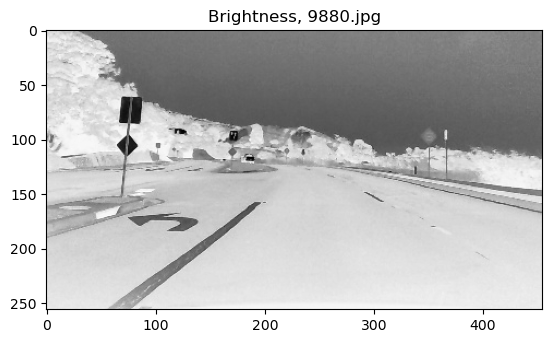

In [7]:
plt.imshow(brightness, cmap='Greys')
plt.title(f'Brightness, {sample_img_idx}.jpg')
plt.show()

To clean up the data a little further, we will want to only look at images that correspond to significant enough steering angles (`min_angle`)and do not exceed a complete half turn (180°). We will do this while retaining enough data to allow for worthwhile model building (`min_data`). We will adjust `min_data` until we subjectively decide upon a good balance between the two values:

In [8]:
min_data = 7000
min_angle = 0

little_left = angles['Angle'] <= -min_angle
little_right = angles['Angle'] >= min_angle
left_max = angles['Angle'] >= -180
right_max = angles['Angle'] <= 180
actually_steering = angles[(little_left & left_max) | (little_right & right_max)]

while actually_steering.shape[0] >= min_data:
    min_angle += 0.5
    little_left = angles['Angle'] <= -min_angle
    little_right = angles['Angle'] >= min_angle
    left_max = angles['Angle'] >= -180
    right_max = angles['Angle'] <= 180
    actually_steering = angles[(little_left & left_max) | (little_right & right_max)]

print(f'Number of examples: {actually_steering.shape[0]}\nMinimum steering angle: {min_angle}°\n')

Number of examples: 6870
Minimum steering angle: 28.0°



One more quality to ensure is that we have (close to) an equivalent number of `left_turn` and `right_turn` datapoints from which we will train and test:

In [9]:
actually_steering = actually_steering.sort_values(by='Angle')
actually_steering.head()
i = 0
while actually_steering['Angle'].iloc[i] < 0:
    i += 1

ang = actually_steering['Angle'].iloc[i-1]
mid = int(len(actually_steering.index)/2)
print(f'Final left turn image at index {i-1} ({ang}°). Midpoint at index {mid}')
diff = mid - i-1

left_turns = actually_steering[0:i-1]
# selects the middle len(left_turns) number of right_turns 
right_turns = actually_steering[mid+int(diff/2)+1:len(actually_steering)-1-int(diff/2)]

print(left_turns.describe(), '\n', right_turns.describe())
actually_steering = pd.concat([left_turns, right_turns])

Final left turn image at index 3169 (-28.030001°). Midpoint at index 3435
             Angle
count  3169.000000
mean    -64.298504
std      33.482429
min    -180.000000
25%     -74.019997
50%     -57.180000
75%     -37.919998
max     -28.030001 
              Angle
count  3169.000000
mean     51.113660
std      18.030260
min      29.450001
25%      36.610001
50%      46.389999
75%      62.820000
max     118.489998


Now let's look at a left turn image as compared to a right turn image:

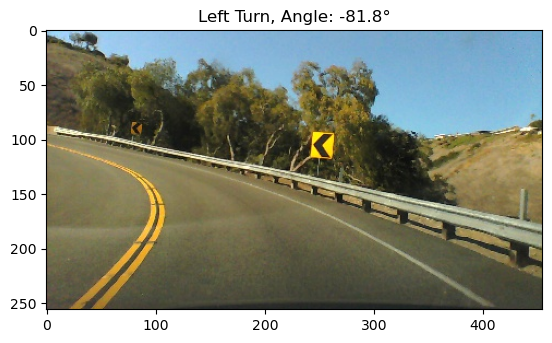

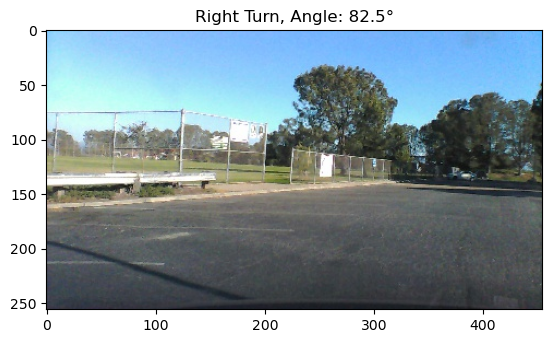

In [10]:
actually_steering = actually_steering.sort_values(by='Angle')
l = int(actually_steering.shape[0]*0.10)
r = int(actually_steering.shape[0]*0.96)
l_img = actually_steering['Image'].iloc[l]
r_img = actually_steering['Image'].iloc[r]
l_angle = actually_steering['Angle'].iloc[l]
r_angle = actually_steering['Angle'].iloc[r]

left_img = cv2.imread(f'images/{l_img}')
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
plt.imshow(left_img)
plt.title(f'Left Turn, Angle: {np.round(l_angle, 1)}°')
plt.show()

right_img = cv2.imread(f'images/{r_img}')
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
plt.imshow(right_img)
plt.title(f'Right Turn, Angle: {np.round(r_angle, 1)}°')
plt.show()

Having explored the images and angles, let's create a DataFrame of the relevant data. Columns [0:len(df)-1] will correspond to the brightness values of each pixel while Column [len(df)-1] will contain its corresponding steering angle.

We will first convert all images to grayscale vectorized lists of effective brightness values (shape: 1 x n_px). We will also scale the resolution of the images down to ~25% of their original widths and heights. This will take us from 116,480 pixels to 7,232 pixels (113 px W x 63 px H).

Doing this in conjunction with looking at only the brightness of each pixel retains the vast majority of the relational information between each pixel while reducing the number of columns by a factor of (0.25 x 0.25 x 0.33) 48:

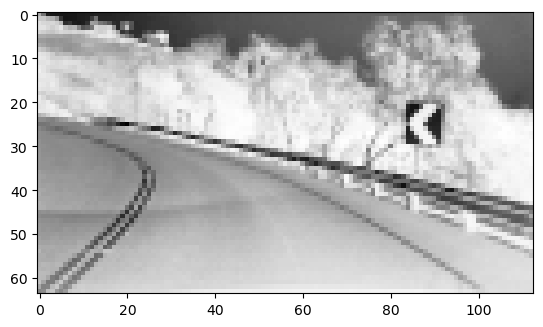

In [11]:
vect_images = []

scale = 0.25

for img in range(actually_steering.shape[0]):
    filename = actually_steering['Image'].iloc[img]
    vect_img = cv2.imread(f'images/{filename}')
    vect_img = cv2.resize(vect_img, (int(vect_img.shape[1]*scale), int(vect_img.shape[0]*scale)), interpolation = cv2.INTER_AREA)
    vect_img = cv2.cvtColor(vect_img, cv2.COLOR_BGR2GRAY)
    vect_images.append(np.concatenate(vect_img).ravel())
    if img == 621:
        temp = cv2.imread(f'images/{filename}')
        temp = cv2.resize(temp, (int(temp.shape[1]*scale), int(temp.shape[0]*scale)), interpolation = cv2.INTER_AREA)
        plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY), cmap='Grays')
        plt.show()

In [12]:
# Run this cell only once, or rerun the above cell first for every rerunning of this cell.
col_names = [f'px_{i}' for i in range(len(vect_images[0]))]
df = pd.DataFrame(vect_images, index = actually_steering.index, columns = col_names)
df = df/df.max() # normalize

df.insert(df.shape[1], 'Angle', actually_steering['Angle'])

df.head()

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_7223,px_7224,px_7225,px_7226,px_7227,px_7228,px_7229,px_7230,px_7231,Angle
22890,0.984314,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.168627,0.172549,0.180392,0.188235,0.207843,0.215686,0.219608,0.219608,0.219608,-180.000000
24479,0.611765,0.635294,0.650980,0.647059,0.650980,0.647059,0.650980,0.658824,0.658824,0.666667,...,0.482353,0.478431,0.490196,0.478431,0.494118,0.490196,0.486275,0.470588,0.478431,-179.899994
23215,0.866667,0.894118,0.898039,0.898039,0.898039,0.898039,0.890196,0.886275,0.890196,0.882353,...,0.294118,0.298039,0.301961,0.305882,0.298039,0.298039,0.313725,0.317647,0.313725,-179.800003
23205,0.807843,0.835294,0.847059,0.847059,0.850980,0.843137,0.835294,0.843137,0.839216,0.835294,...,0.333333,0.325490,0.333333,0.329412,0.333333,0.333333,0.333333,0.341176,0.345098,-179.800003
23216,0.866667,0.890196,0.898039,0.894118,0.901961,0.898039,0.894118,0.890196,0.886275,0.882353,...,0.294118,0.298039,0.298039,0.309804,0.305882,0.301961,0.301961,0.313725,0.317647,-179.389999


We will now create a `discrete_turns_df` DataFrame from a pair of `discrete_left` and `discrete_right` DataFrames. We will simplify each `'Angle'` column to -1 for left turns and 1 for right turns. 

In [13]:
discrete_left = df[df['Angle'] < 0]
discrete_left.loc[:, 'Angle'] = -1

discrete_right = df[df['Angle'] > 0]
discrete_right.loc[:, 'Angle'] = 1

discrete_turns_df = pd.concat([discrete_right, discrete_left], axis=0)
discrete_turns_df['Angle'] = discrete_turns_df['Angle'].astype(int)

In [28]:
# Create some helper functions and a DataFrame into which various statistics will be stored
def calc_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)
    
def calc_precision(y_true, y_pred, pos_label_value=1.0):
    return precision_score(y_true, y_pred, pos_label=pos_label_value)

def calc_recall(y_true, y_pred, pos_label_value=1.0):
    return recall_score(y_true, y_pred, pos_label=pos_label_value)

runtimes = {}

stats_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'k', 'max_depth', 'max_leaf_nodes']
stats = pd.DataFrame(columns = stats_cols)

In [29]:
# Split the dataframe into training and testing subsets
x = np.array(discrete_turns_df.iloc[:, :-1])
y = np.array(discrete_turns_df['Angle'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=5)

<br><br>
We have now concluded our exploratory data analysis, data cleaning, and data preparation. We went from 63,825 rows of data to  rows of data. We also went from (455 px W x 256 px H x 3 color channels) 349,440 columns of feature data down to just (113 x 63 x 1) 7,119 columns. This will make the model training quicker and more abstracted. It will also prevent the models from being distracted by very similar images and/or potential noise that would be present in higher resolution images.

## Model 1: Logistic Regression

In [30]:
LogReg = LogisticRegression(solver='liblinear').fit(x_train, y_train)

log_reg_acc = np.round(calc_accuracy(y_test, LogReg.predict(x_test))*100, 1)
log_reg_prec = np.round(calc_precision(y_test, LogReg.predict(x_test))*100, 1)
log_reg_recall = np.round(calc_recall(y_test, LogReg.predict(x_test))*100, 1)
print(f'Logistic Regression\nAccuray: {log_reg_acc}% |',
      f'Precision: {log_reg_prec}% |',
      f'Recall: {log_reg_recall}%')

Logistic Regression
Accuray: 93.6% | Precision: 92.8% | Recall: 94.4%


In [31]:
lr_stats_df = pd.DataFrame({stats_cols[0]: 'LogReg',
                            stats_cols[1]: log_reg_acc,
                            stats_cols[2]: log_reg_prec,
                            stats_cols[3]: log_reg_recall,
                            stats_cols[4]: pd.NA,
                            stats_cols[5]: pd.NA,
                            stats_cols[6]: pd.NA},
                          index=[len(stats)])
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    stats = pd.concat([stats, lr_stats_df])

# Model 2: kNN

In [32]:
class KNN:

    def __init__(self, x_train, y_train, K = 5):
        self.balltree = BallTree(x_train)
        self.y_train = y_train
        self.K = K
        
        
    def majority(self, neighbor_indices, neighbor_distances = None):
        label, tiebreak_k = 0, self.K
        categories = np.unique(self.y_train)
        label_count = [0]*len(categories)
        
        while True:
            for i in neighbor_indices[0:tiebreak_k]:
                if self.y_train[i] == -1:
                    label_count[0] += 1
                else:
                    label_count[1] += 1
    
            if label_count[0] > label_count[1]:
                return -1
            elif label_count[0] < label_count[1]:
                return 1
            else:
                tiebreak_k -= 1
                
        
    def classify(self, x):
        dist, ind = self.balltree.query(np.array([x]), k = self.K)
        return self.majority(ind[0], dist[0])
        

    def predict(self, X):
        yhat = []
        for i in X:
            yhat.append(self.classify(i))
        return yhat

In [33]:
for k in range(3, 22, 2):

    kNN = KNN(x_train, y_train, K=k)
    
    kNN_acc = np.round(calc_accuracy(y_test, kNN.predict(x_test))*100, 2)
    kNN_prec = np.round(calc_precision(y_test, kNN.predict(x_test))*100, 2)
    kNN_recall = np.round(calc_recall(y_test, kNN.predict(x_test))*100, 2)
    print(f'kNN (K = {k})\nAccuracy: {kNN_acc}% |',
          f'Precision: {kNN_prec}% |',
          f'Recall: {kNN_recall}%\n')

    knn_stats_df = pd.DataFrame({stats_cols[0]: f'kNN',
                                 stats_cols[1]: kNN_acc,
                                 stats_cols[2]: kNN_prec,
                                 stats_cols[3]: kNN_recall,
                                 stats_cols[4]: k,
                                 stats_cols[5]: pd.NA,
                                 stats_cols[6]: pd.NA},
                                index=[len(stats)])
    stats = pd.concat([stats, knn_stats_df])

kNN (K = 3)
Accuracy: 99.92% | Precision: 99.84% | Recall: 100.0%

kNN (K = 5)
Accuracy: 99.76% | Precision: 99.52% | Recall: 100.0%

kNN (K = 7)
Accuracy: 99.61% | Precision: 99.36% | Recall: 99.84%

kNN (K = 9)
Accuracy: 98.9% | Precision: 98.72% | Recall: 99.04%

kNN (K = 11)
Accuracy: 98.58% | Precision: 98.41% | Recall: 98.72%

kNN (K = 13)
Accuracy: 98.5% | Precision: 98.1% | Recall: 98.88%

kNN (K = 15)
Accuracy: 98.11% | Precision: 97.77% | Recall: 98.4%

kNN (K = 17)
Accuracy: 96.77% | Precision: 95.77% | Recall: 97.76%

kNN (K = 19)
Accuracy: 96.14% | Precision: 95.0% | Recall: 97.28%

kNN (K = 21)
Accuracy: 95.11% | Precision: 93.92% | Recall: 96.32%



## Model 3: Decision Tree

In [34]:
for i in range(3, 22, 2):

    dtc = DecisionTreeClassifier(max_depth=i).fit(x_train, y_train)
        
    dtc_acc = np.round(calc_accuracy(y_test, dtc.predict(x_test))*100, 2)
    dtc_prec = np.round(calc_precision(y_test, dtc.predict(x_test))*100, 2)
    dtc_recall = np.round(calc_recall(y_test, dtc.predict(x_test))*100, 2)
    print(f'Decision Tree (max_depth = {i})\nAccuracy: {dtc_acc}% |',
          f'Precision: {dtc_prec}% |',
          f'Recall: {dtc_recall}%\n')

    dtc_stats_df = pd.DataFrame({stats_cols[0]: f'Decision Tree',
                                 stats_cols[1]: dtc_acc,
                                 stats_cols[2]: dtc_prec,
                                 stats_cols[3]: dtc_recall,
                                 stats_cols[4]: pd.NA,
                                 stats_cols[5]: i,
                                 stats_cols[6]: pd.NA},
                                index=[len(stats)])
    stats = pd.concat([stats, dtc_stats_df])

Decision Tree (max_depth = 3)
Accuracy: 73.9% | Precision: 74.58% | Recall: 71.36%

Decision Tree (max_depth = 5)
Accuracy: 83.36% | Precision: 83.71% | Recall: 82.24%

Decision Tree (max_depth = 7)
Accuracy: 86.91% | Precision: 86.26% | Recall: 87.36%

Decision Tree (max_depth = 9)
Accuracy: 90.69% | Precision: 91.09% | Recall: 89.92%

Decision Tree (max_depth = 11)
Accuracy: 90.77% | Precision: 90.19% | Recall: 91.2%

Decision Tree (max_depth = 13)
Accuracy: 91.48% | Precision: 91.76% | Recall: 90.88%

Decision Tree (max_depth = 15)
Accuracy: 91.25% | Precision: 91.19% | Recall: 91.04%

Decision Tree (max_depth = 17)
Accuracy: 90.85% | Precision: 90.21% | Recall: 91.36%

Decision Tree (max_depth = 19)
Accuracy: 91.17% | Precision: 90.65% | Recall: 91.52%

Decision Tree (max_depth = 21)
Accuracy: 90.93% | Precision: 89.97% | Recall: 91.84%



In [35]:
for i in range(10, 201, int((201-10)/10)):
    
    dtc = DecisionTreeClassifier(max_leaf_nodes=i).fit(x_train, y_train)
    
    dtc_acc = np.round(calc_accuracy(y_test, dtc.predict(x_test))*100, 2)
    dtc_prec = np.round(calc_precision(y_test, dtc.predict(x_test))*100, 2)
    dtc_recall = np.round(calc_recall(y_test, dtc.predict(x_test))*100, 2)
    print(f'Decision Tree (max_leaf_nodes = {i})\nAccuracy: {dtc_acc}% |',
          f'Precision: {dtc_prec}% |',
          f'Recall: {dtc_recall}%\n')

    dtc_stats_df = pd.DataFrame({stats_cols[0]: f'Decision Tree',
                                 stats_cols[1]: dtc_acc,
                                 stats_cols[2]: dtc_prec,
                                 stats_cols[3]: dtc_recall,
                                 stats_cols[4]: pd.NA,
                                 stats_cols[5]: pd.NA,
                                 stats_cols[6]: i},
                                index=[len(stats)])
    
    stats = pd.concat([stats, dtc_stats_df])

Decision Tree (max_leaf_nodes = 10)
Accuracy: 75.55% | Precision: 75.61% | Recall: 74.4%

Decision Tree (max_leaf_nodes = 29)
Accuracy: 84.23% | Precision: 82.34% | Recall: 86.56%

Decision Tree (max_leaf_nodes = 48)
Accuracy: 86.91% | Precision: 85.8% | Recall: 88.0%

Decision Tree (max_leaf_nodes = 67)
Accuracy: 89.04% | Precision: 87.97% | Recall: 90.08%

Decision Tree (max_leaf_nodes = 86)
Accuracy: 89.59% | Precision: 88.7% | Recall: 90.4%

Decision Tree (max_leaf_nodes = 105)
Accuracy: 89.91% | Precision: 89.51% | Recall: 90.08%

Decision Tree (max_leaf_nodes = 124)
Accuracy: 91.17% | Precision: 90.91% | Recall: 91.2%

Decision Tree (max_leaf_nodes = 143)
Accuracy: 90.77% | Precision: 90.32% | Recall: 91.04%

Decision Tree (max_leaf_nodes = 162)
Accuracy: 91.01% | Precision: 90.75% | Recall: 91.04%

Decision Tree (max_leaf_nodes = 181)
Accuracy: 90.85% | Precision: 90.21% | Recall: 91.36%

Decision Tree (max_leaf_nodes = 200)
Accuracy: 91.64% | Precision: 91.92% | Recall: 91.04%


## Statistics and Analysis

First let's print the dataframe of statistical information we've collected from the various models:

In [36]:
print(stats)

            Model  Accuracy  Precision  Recall    k max_depth max_leaf_nodes
0          LogReg     93.60      92.80   94.40  NaN       NaN            NaN
1             kNN     99.92      99.84  100.00    3       NaN            NaN
2             kNN     99.76      99.52  100.00    5       NaN            NaN
3             kNN     99.61      99.36   99.84    7       NaN            NaN
4             kNN     98.90      98.72   99.04    9       NaN            NaN
5             kNN     98.58      98.41   98.72   11       NaN            NaN
6             kNN     98.50      98.10   98.88   13       NaN            NaN
7             kNN     98.11      97.77   98.40   15       NaN            NaN
8             kNN     96.77      95.77   97.76   17       NaN            NaN
9             kNN     96.14      95.00   97.28   19       NaN            NaN
10            kNN     95.11      93.92   96.32   21       NaN            NaN
11  Decision Tree     73.90      74.58   71.36  NaN         3            NaN

Now let's examine how these performed. We'll start by comparing the kNN models across various k-values:

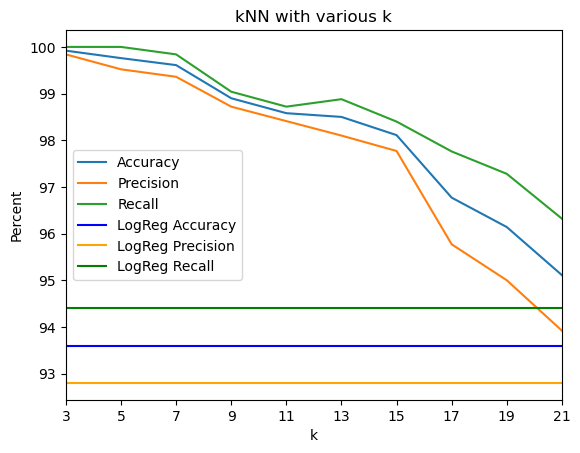

In [42]:
# Plot the various statistics related to the kNN models
plt.plot(stats.iloc[1:11]['k'], stats.iloc[1:11]['Accuracy'], label='Accuracy')
plt.plot(stats.iloc[1:11]['k'], stats.iloc[1:11]['Precision'], label='Precision')
plt.plot(stats.iloc[1:11]['k'], stats.iloc[1:11]['Recall'], label='Recall')
plt.axhline(y=stats.iloc[0]['Accuracy'], label='LogReg Accuracy', color='blue')
plt.axhline(y=stats.iloc[0]['Precision'], label='LogReg Precision', color='orange')
plt.axhline(y=stats.iloc[0]['Recall'], label='LogReg Recall', color='green')
plt.title('kNN with various k')

plt.xlabel('k')
plt.xlim(3, 21)
plt.xticks(range(3, 22, 2))

plt.ylabel('Percent')

plt.legend()

plt.show()

As expected, the models generally tend to perform better as we decrease the number of allowed nearest neighbors (k). These models all did much better than the baseline Logistic Regression model.

Looking at the Decision Tree models with varying `max_depth` values:

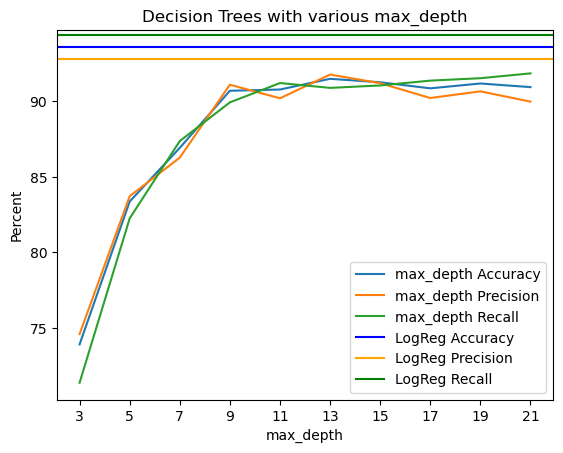

In [38]:
# Plot the various statistics related to the Decision Tree models with varying max_depth
plt.plot(stats.iloc[11:21]['max_depth'], stats.iloc[11:21]['Accuracy'], label='max_depth Accuracy')
plt.plot(stats.iloc[11:21]['max_depth'], stats.iloc[11:21]['Precision'], label='max_depth Precision')
plt.plot(stats.iloc[11:21]['max_depth'], stats.iloc[11:21]['Recall'], label='max_depth Recall')
plt.axhline(y=stats.iloc[0]['Accuracy'], label='LogReg Accuracy', color='blue')
plt.axhline(y=stats.iloc[0]['Precision'], label='LogReg Precision', color='orange')
plt.axhline(y=stats.iloc[0]['Recall'], label='LogReg Recall', color='green')
plt.title('Decision Trees with various max_depth')

plt.xlabel('max_depth')
plt.xticks(range(3, 22, 2))

plt.ylabel('Percent')

plt.legend()

plt.show()

It can be observed that generally speaking, the deeper the tree, the better the model performed. However there is a point of diminishing returns around the depth of 10. Not only that, but it can be observed that the 3 statistical metrics of interest here seem to trend nearly identically until the recall and precision begin to diverge beyond a max_depth of 15. It should also be observed that no matter how deep this single tree, it never met or exceeded the accuracy, precision, or recall of the Logistic Regression model.

Lastly, we will look at the Decision Tree models with varying `max_leaf_nodes` values:

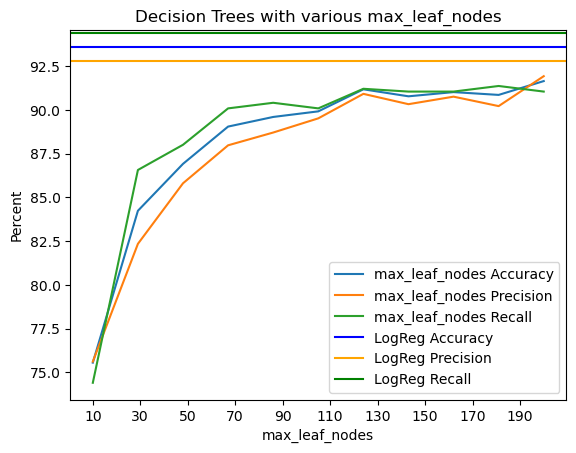

In [39]:
# Plot the various statistics related to the Decision Tree models with varying max_leaf_nodes
plt.plot(stats.iloc[21:32]['max_leaf_nodes'], stats.iloc[21:32]['Accuracy'], label='max_leaf_nodes Accuracy')
plt.plot(stats.iloc[21:32]['max_leaf_nodes'], stats.iloc[21:32]['Precision'], label='max_leaf_nodes Precision')
plt.plot(stats.iloc[21:32]['max_leaf_nodes'], stats.iloc[21:32]['Recall'], label='max_leaf_nodes Recall')
plt.axhline(y=stats.iloc[0]['Accuracy'], label='LogReg Accuracy', color='blue')
plt.axhline(y=stats.iloc[0]['Precision'], label='LogReg Precision', color='orange')
plt.axhline(y=stats.iloc[0]['Recall'], label='LogReg Recall', color='green')
plt.title('Decision Trees with various max_leaf_nodes')

plt.xlabel('max_leaf_nodes')
plt.xticks(range(10, 200, 20))

plt.ylabel('Percent')

plt.legend()

plt.show()

As expected, these statistics show a very similar trend to the variable max_depth DecisionTreeClassifiers in that the more complex the model, generally the better it performs. The recall seemed to improve faster than the precision with simpler trees, but this trend ultimately reversed beyond a max_leaf_nodes value of about 180.

## Conclusion

In conclusion, all of these models did relatively well at achieving the goal of correctly classifying the images. This is especially noteworthy given the variability in the data (many images of parking lots, intersections, shadows, dirty camera lense, etc.) One thing to note is the DecisionTreeClassifier models vastly underperformed the simple Logistic Regression model and kNN models. For this reason, exploring how various ensemble methods (e.g., random forest, ) could improve the performance would likely be worthwhile. The kNN models on the other hand performed quite well- exceeding the Logistic Regression model in all key metrics. These models did however take the longest to run, accumulating to over 30 minutes for the 10 different k-values selected.

Due to the complexity of the dataset, I was not able to successfully execute a correlation matrix. However I do anticipate many of the features being highly correlated. For example, all pixels in the lower middle of the screen (middle of the road right in front of the car) were almost always black. If they changed shade, it would likely be a uniform change for the many pixels in this region as it is almost always representative of relatively homogeneous pavement. It would be intersting to see how the models would perform having removed these features.

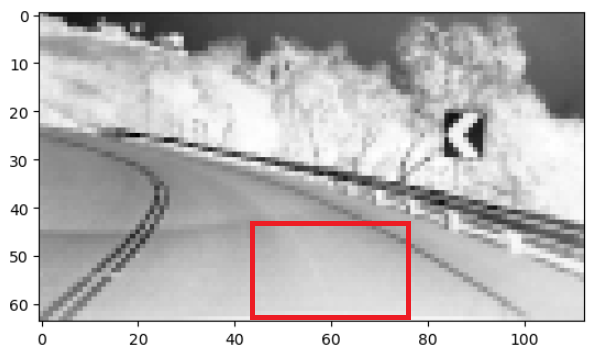

Given the 3 models analyzed in this study, I would opt for a kNN model with k=3 to classify any images as left_turn or right_turn.